In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from embeddings import get_embedding_matrix, sentence_to_indexes
from emb_path import glove_6B_300d_path, lexvec_7B_300d_path, glove_6B_50d_path
from sklearn.metrics.pairwise import cosine_similarity
from gem import SentenceEmbedder
from scipy.stats import pearsonr
from utils import read_sts
import os
from tqdm import tqdm_notebook as tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Prepare datasets

In [6]:
IMDB_PATH = './data/imdb'

IMDB_TRAIN = os.path.join(IMDB_PATH, 'train')
IMDB_TRAIN_POS = os.path.join(IMDB_TRAIN, 'pos')
IMDB_TRAIN_NEG = os.path.join(IMDB_TRAIN, 'neg')

IMDB_TEST = os.path.join(IMDB_PATH, 'test')

In [7]:
train_pos_samples = [os.path.join(IMDB_TRAIN_POS, s) for s in os.listdir(IMDB_TRAIN_POS)]
train_neg_samples = [os.path.join(IMDB_TRAIN_NEG, s) for s in os.listdir(IMDB_TRAIN_NEG)]

test_samples = [os.path.join(IMDB_TEST, s) for s in os.listdir(IMDB_TEST)]

In [8]:
print(len(train_pos_samples), len(train_neg_samples), len(test_samples))

12500 12500 11001


# Process every review

In [9]:
import nltk.data

In [10]:
# nltk.download('punkt')

In [11]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [12]:
pos_reviews = []
neg_reviews = []


for review in tqdm(train_pos_samples[:]):
    try:
        with open(review, 'r', encoding="utf-8") as file:
            data = file.read().replace('\n', '')
            data = data.replace('<br />', ' ')
    #             data = data.replace('.', '')
    #         data_sentences = tokenizer.tokenize(data)
            pos_reviews += [data]
    except UnicodeDecodeError:
        continue
    

for review in tqdm(train_neg_samples[:]):
    try:
        with open(review, 'r', encoding="utf-8") as file:
            data = file.read().replace('\n', '')
            data = data.replace('<br />', ' ')
    #             data = data.replace('.', '')
    #         data_sentences = tokenizer.tokenize(data)
            neg_reviews += [data]
    except UnicodeDecodeError:
        continue

In [13]:
labels = [1]*len(pos_reviews) + [0]*len(neg_reviews)
reviews = pos_reviews + neg_reviews
print(len(reviews))

25000


In [14]:
reviews[0]

'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!'

# Compute embeddings of entire reviews

In [15]:
embds = {"Glove": get_embedding_matrix(glove_6B_300d_path)}

In [13]:
%%time

embeddings = []

print('Unigrams:\n\n')

for e_name, (e, v) in embds.items():
    model = SentenceEmbedder(reviews, e, v, False)
    result, s = model.gem(sigma_power=3)
    embeddings += [result]

Unigrams:




25000it [22:18, 18.67it/s]
4767it [24:30,  3.24it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

25000it [2:09:01,  3.23it/s]

CPU times: user 13h 48min 37s, sys: 1d 18h 1min 28s, total: 2d 7h 50min 5s
Wall time: 2h 31min 26s


In [16]:
embeddings[0].shape

(25000, 300)

In [17]:
np.save('imdb_embeddings.npy', embeddings[0])

In [40]:
imdb_embeddings = np.load('./data/imdb_embeddings.npy')

In [28]:
train_imdb = np.append(imdb_embeddings[:1800], imdb_embeddings[12500:14300], axis=0)
train_imdb_labels = np.array([1]*1800+[0]*1800)

test_imdb = np.append(imdb_embeddings[1800:2000], imdb_embeddings[14300:14500], axis=0)
test_imdb_labels = np.array([1]*200+[0]*200)

# Compute embeddings of separated sentences

In [14]:
%%time

embeddings = []

print('Unigrams:\n\n')

for review in tqdm(reviews[:2000]):
    sentences = tokenizer.tokenize(review)
    for e_name, (e, v) in embds.items():
        model = SentenceEmbedder(sentences, e, v, False)
        result, s = model.gem(sigma_power=3)
        review_embedding = np.mean(result, axis=0)
    embeddings += [review_embedding]
    
for review in tqdm(reviews[12500:14500]):
    sentences = tokenizer.tokenize(review)
    for e_name, (e, v) in embds.items():
        model = SentenceEmbedder(sentences, e, v, False)
        result, s = model.gem(sigma_power=3)
        review_embedding = np.mean(result, axis=0)
    embeddings += [review_embedding]

Unigrams:




Exception in thread Thread-6:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/opt/conda/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




CPU times: user 3h 2min 49s, sys: 10h 39min 8s, total: 13h 41min 58s
Wall time: 19min 37s


In [ ]:
%%time

embeddings = []

print('Unigrams:\n\n')

for review in tqdm(reviews[:2000]):
    sentences = tokenizer.tokenize(review)
    for e_name, (e, v) in embds.items():
        model = SentenceEmbedder(sentences, e, v, False)
        result, s = model.gem(sigma_power=3)
        review_embedding = np.mean(result, axis=0)
    embeddings += [review_embedding]
    
for review in tqdm(reviews[12500:14500]):
    sentences = tokenizer.tokenize(review)
    for e_name, (e, v) in embds.items():
        model = SentenceEmbedder(sentences, e, v, False)
        result, s = model.gem(sigma_power=3)
        review_embedding = np.mean(result, axis=0)
    embeddings += [review_embedding]

In [18]:
embeddings = np.array(embeddings)

In [21]:
train_imdb = np.append(embeddings[:1800], embeddings[2000:3800], axis=0)
train_imdb_labels = np.array([1]*1800+[0]*1800)

test_imdb = np.append(embeddings[1800:2000], embeddings[3800:], axis=0)
test_imdb_labels = np.array([1]*200+[0]*200)

In [49]:
embeddings.shape

(4000, 300)

In [52]:
np.save('embeddings.npy', embeddings)

In [16]:
embeddings = np.load('embeddings.npy')

# Treat sentences as words 

In [33]:
%%time

sent_words_embeddings = []

print('Unigrams:\n\n')

for review in tqdm(reviews[:2000]):
    sentences = tokenizer.tokenize(review)
    emb_sent = []
    for e_name, (e, v) in embds.items():
        model = SentenceEmbedder(sentences, e, v, None, False)
        result, s = model.gem(sigma_power=3)
        emb_sent = emb_sent + [result]
    emb_sent = np.array(emb_sent)
    model = SentenceEmbedder(sentences, e, v, emb_sent, False)
    result, s = model.gem_sentences(sigma_power=3)
    review_embedding = np.mean(result, axis=0)
    sent_words_embeddings += [review_embedding]
    
for review in tqdm(reviews[12500:14500]):
    sentences = tokenizer.tokenize(review)
    emb_sent = []
    for e_name, (e, v) in embds.items():
        model = SentenceEmbedder(sentences, e, v, None, False)
        result, s = model.gem(sigma_power=3)
        emb_sent = emb_sent + [result]
    emb_sent = np.array(emb_sent)
    model = SentenceEmbedder(sentences, e, v, emb_sent, False)
    result, s = model.gem_sentences(sigma_power=3)
    review_embedding = np.mean(result, axis=0)
    sent_words_embeddings += [review_embedding]

Unigrams:




Exception in thread Thread-16:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/opt/conda/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




CPU times: user 3h 7min 4s, sys: 10h 58min 44s, total: 14h 5min 48s
Wall time: 22min


In [35]:
train_imdb = np.append(sent_words_embeddings[:1800], sent_words_embeddings[2000:3800], axis=0)
train_imdb_labels = np.array([1]*1800+[0]*1800)

test_imdb = np.append(sent_words_embeddings[1800:2000], sent_words_embeddings[3800:], axis=0)
test_imdb_labels = np.array([1]*200+[0]*200)

# Fit&Predict

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [30]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(train_imdb, train_imdb_labels)

In [31]:
y = clf.predict(test_imdb)

In [32]:
np.mean(y == test_imdb_labels)

0.6825

In [23]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(train_imdb, train_imdb_labels)

In [24]:
y = clf.predict(test_imdb)
np.mean(y == test_imdb_labels)

0.6175

In [42]:
def xval(x, size):
    middle = len(x)//2
    x = np.append(x[:size//2], x[middle:middle+size//2], axis=0)
    y = [0]*(size//2) + [1]*(size//2)
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr')
    scores = cross_val_score(clf, x, y, cv=5)
    return scores

In [37]:
scores = xval(embeddings, 2000)

In [41]:
separate_sentences_score = np.mean(scores)

In [42]:
separate_sentences_score

0.6185

In [43]:
full_reviews_scores = []
for size in tqdm(range(2000,25000,1000)):
    score = np.mean(xval(imdb_embeddings, size))
    full_reviews_scores += [score]

In [44]:
full_reviews_scores

[0.6529999999999999,
 0.6786666666666666,
 0.67825,
 0.6845999999999999,
 0.684,
 0.6970000000000001,
 0.703875,
 0.7030000000000001,
 0.7093999999999999,
 0.7064545454545454,
 0.7109166666666666,
 0.7208461538461538,
 0.7231428571428571,
 0.7243333333333334,
 0.7218125000000001,
 0.7226470588235294,
 0.7253888888888887,
 0.7237368421052632,
 0.72405,
 0.7248095238095237,
 0.7261818181818182,
 0.7274782608695654,
 0.7262083333333333]

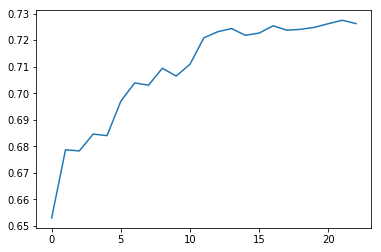

In [48]:
plt.plot(full_reviews_scores)
plt.show()

In [38]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(train_imdb, train_imdb_labels)

In [39]:
y = clf.predict(test_imdb)
np.mean(y == test_imdb_labels)

0.565